Rebalance example.

In [1]:
# set up Python
import logging
import os
from math import comb
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.optimize import fsolve
from cmdstanpy import CmdStanModel
from plotnine import *

In [2]:
# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(2024)

In [4]:
run_Hidden_selections = False


In [5]:
list_size = 5
m_lists = 1000
explanatory_variables = ('x1', 'x2', 'x3')

m_others = 8
m_prefix = 4
d = pd.DataFrame({
    'example_index': range(m_prefix - 1 + m_others),
    'x1': [12., 1., 0. ] + m_others * [0.],
    'x2': [1. , 6., 0. ] + m_others * [1.],
    'x3': [0. , 0., 0.1] + m_others * [1.],
})

d.round(2)

,example_index,x1,x2,x3
0,0,12.0,1.0,0.0
1,1,1.0,6.0,0.0
2,2,0.0,0.0,0.1
3,3,0.0,1.0,1.0
4,4,0.0,1.0,1.0
5,5,0.0,1.0,1.0
6,6,0.0,1.0,1.0
7,7,0.0,1.0,1.0
8,8,0.0,1.0,1.0
9,9,0.0,1.0,1.0


In [6]:
# confirm we have a full rank system
design_mat = np.append(
    np.array(d.loc[range(m_prefix), list(explanatory_variables)]),
    np.zeros((m_prefix, 1), dtype=float) + 1, 
    axis=1)
assert np.abs(np.linalg.det(design_mat)) > 1e-3

In [7]:
def sigmoid(v):
    return 1 / (1 + np.exp(-v))

In [8]:
def logit(v):
    return  np.log(v / (1-v))

In [9]:
def mk_coef_frame(name: str, *, b_0, coef):
    coef_frame = {
        'model': name,
        'beta_0': [b_0],
        }
    for i, v in enumerate(explanatory_variables):
        coef_frame[v] = coef[i]
    coef_frame = pd.DataFrame(coef_frame)
    return coef_frame

In [10]:
b_orig_0 = -1.2
b_orig = np.zeros(len(explanatory_variables), dtype=float) + 0.2

d['data generation process'] = sigmoid((d.loc[:, list(explanatory_variables)] @ b_orig) + b_orig_0)

coef_frame = mk_coef_frame('data generation process', b_0=b_orig_0, coef=b_orig)



In [11]:
coef_frame.round(2)

,model,beta_0,x1,x2,x3
0,data generation process,-1.2,0.2,0.2,0.2


In [12]:
d.loc[range(m_prefix), :].round(2)

,example_index,x1,x2,x3,data generation process
0,0,12.0,1.0,0.0,0.80
1,1,1.0,6.0,0.0,0.55
2,2,0.0,0.0,0.1,0.24
3,3,0.0,1.0,1.0,0.31


In [13]:
def select_one_per_group(
    d,
    *,
    group_column_name: str,
    score_column_name: str,
    ):
    # copy frame
    d = pd.DataFrame({
        'pick_key': -np.array(list(reversed(range(1, d.shape[0] + 1))), dtype=float),  # all negative
        'group': d[group_column_name],
        'score': d[score_column_name],
    })
    d['max_score'] = d.groupby(['group'])['score'].transform('max')
    d['pick_key'] = (d['score'] >= d['max_score']) * d['pick_key']
    d['min_pick_key'] = d.groupby(['group'])['pick_key'].transform('min')
    res = np.array(d['pick_key'] == d['min_pick_key'])
    d['res'] = res
    res_check = d.groupby(['group'])['res'].sum()
    assert np.all(res_check == 1)
    return res

In [14]:
def build_list_examples(
    d: pd.DataFrame,
    *,
    explanatory_variables,
    b_orig_0,
    b_orig,
    wts = None,
    list_size,
    m_lists,
) -> pd.DataFrame:
    if wts is None:
        wts = 1.0 + np.zeros(d.shape[0])
    wts = np.array(wts) / np.sum(wts)
    assert np.all(wts >= 0)
    d = d.loc[:, ['example_index'] + list(explanatory_variables)].reset_index(drop=True, inplace=False)  # copy

    d['weight'] = wts
    d['score'] = sigmoid((d.loc[:, explanatory_variables] @ b_orig) + b_orig_0)
    re_samples_indexes = []
    for list_i in range(m_lists):
        re_samples_indexes.extend(list(rng.choice(d.shape[0], list_size, replace=False, p=wts)))
    resampled_frame = pd.DataFrame({
        'group': [i // list_size for i in range(m_lists * list_size)],
        'position': [i % list_size for i in range(m_lists * list_size)],
        'example_index' : re_samples_indexes,
    })
    resampled_frame = pd.merge(
        resampled_frame,
        d,
        how='inner',
        on=['example_index']
    ).sort_values(['group', 'position'], ignore_index=True, inplace=False)
    resampled_frame['score'] = sigmoid(logit(resampled_frame['score']) + 0.1 * rng.normal(size=resampled_frame.shape[0]))
    resampled_frame['hidden_activation'] = rng.binomial(n=1, p=resampled_frame['score']) > 0
    resampled_frame['effective_score'] = resampled_frame['hidden_activation'] * resampled_frame['score']
    resampled_frame['selected'] = (
        select_one_per_group(resampled_frame, group_column_name='group', score_column_name='effective_score') 
        * resampled_frame['hidden_activation'])
    del resampled_frame['weight']
    del resampled_frame['effective_score']
    return resampled_frame

In [15]:
examples = build_list_examples(
    d,
    b_orig_0=b_orig_0,
    b_orig=b_orig, 
    explanatory_variables=explanatory_variables,
    list_size=list_size,
    m_lists=m_lists,
    )

In [16]:
def highlight_groups(s):
    return ['background-color: lightblue' if (i // list_size) % 2 == 0 else 'background-color: lightgreen' for i in range(len(s))]

def highlight_true(val):
    color = 'background-color: orange' if val is True else ''
    return color

(
    examples
        .head(15)
        .style
        .format("{:.2f}", subset=list(explanatory_variables))
        .format("{:.3f}", subset=['score'])
        .apply(highlight_groups, axis=0)
        .map(highlight_true, subset=['hidden_activation', 'selected'])
)

,group,position,example_index,x1,x2,x3,score,hidden_activation,selected
0,0,0,7,0.00,1.00,1.00,0.295,False,False
1,0,1,2,0.00,0.00,0.10,0.257,False,False
2,0,2,3,0.00,1.00,1.00,0.304,False,False
3,0,3,8,0.00,1.00,1.00,0.288,False,False
4,0,4,10,0.00,1.00,1.00,0.348,False,False
5,1,0,1,1.00,6.00,0.00,0.546,True,False
6,1,1,0,12.00,1.00,0.00,0.796,True,True
7,1,2,3,0.00,1.00,1.00,0.326,True,False
8,1,3,7,0.00,1.00,1.00,0.309,False,False
9,1,4,2,0.00,0.00,0.10,0.210,True,False


In [17]:
# get hidden counts
hidden_counts = (
        examples
            .groupby(['group'])
            ['hidden_activation']
            .sum()
            .value_counts()
            .sort_index()
)
activation_distribution = pd.DataFrame({
    'hidden_choices': range(list_size+1),
})
activation_distribution['count'] = hidden_counts  # uses index to align in

activation_distribution

,hidden_choices,count
0,0,95
1,1,267
2,2,378
3,3,214
4,4,44
5,5,2


In [18]:
# get visible counts
visible_counts = pd.DataFrame({
    'visible count': np.array(
        examples
            .groupby(['group'])
            ['selected']
            .sum()
            .value_counts()
            .sort_index()
    )
})

visible_counts

,visible count
0,95
1,905


In [19]:
# implied average conversion probability
p_implied = 1 - (visible_counts.loc[0, 'visible count']/sum(visible_counts['visible count']))**(1/list_size)

p_implied

0.37548234392376967

In [20]:
activation_distribution['visible 0/1 implied frequency'] = (
    sum(visible_counts['visible count']) * np.array([comb(list_size, i) * p_implied**i * (1-p_implied)**(list_size-i) for i in range(list_size+1)])
)
activation_distribution['relative error'] = (
    (activation_distribution['visible 0/1 implied frequency'] - activation_distribution['count']) 
    / activation_distribution['count']
)

(
    activation_distribution
        .style
        .format("{:.1f}", subset=['visible 0/1 implied frequency'])
        .format("{:.2f}", subset=['relative error'])
)

,hidden_choices,count,visible 0/1 implied frequency,relative error
0,0,95,95.0,-0.00
1,1,267,285.6,0.07
2,2,378,343.4,-0.09
3,3,214,206.5,-0.04
4,4,44,62.1,0.41
5,5,2,7.5,2.73


Fit on (hidden) activations. This recovers the generative coefficients, but relies on data we would not have (so not implementable).

In [21]:
if run_Hidden_selections:
    model_threshold = LogisticRegression()
    model_threshold.fit(
        examples.loc[:, explanatory_variables],
        examples['hidden_activation'],
    )
    d['model from hidden selections'] = model_threshold.predict_proba(d.loc[:, explanatory_variables])[:, 1]
    coef_frame = pd.concat([
        coef_frame,
        mk_coef_frame("model from hidden selections", b_0=model_threshold.intercept_[0], coef=model_threshold.coef_[0])
    ], ignore_index=True)

Try to fit at item level using visible selections (often doesn't work).

In [22]:
model_selected = LogisticRegression()
model_selected.fit(
    examples.loc[:, explanatory_variables],
    examples['selected'],
)
d['model from visible selections'] = model_selected.predict_proba(d.loc[:, explanatory_variables])[:, 1]

coef_frame = pd.concat([
    coef_frame,
    mk_coef_frame("model from visible selections", b_0=model_selected.intercept_[0], coef=model_selected.coef_[0])
], ignore_index=True)

In [23]:
d.loc[range(m_prefix), :].round(2)

,example_index,x1,x2,x3,data generation process,model from visible selections
0,0,12.0,1.0,0.0,0.80,0.80
1,1,1.0,6.0,0.0,0.55,0.39
2,2,0.0,0.0,0.1,0.24,0.04
3,3,0.0,1.0,1.0,0.31,0.10


In [24]:
coef_frame.round(2)

,model,beta_0,x1,x2,x3
0,data generation process,-1.20,0.20,0.20,0.2
1,model from visible selections,-3.13,0.34,0.39,0.5


Try to fit using pair differences (somewhat works).

In [25]:
diff_frame = []
diff_y = []
for group in range(m_lists):
    selected_position = None
    for i in range(list_size * group, list_size * (group + 1)):
        if examples.loc[i, 'selected']:
            selected_position = i
    if selected_position is not None:
        for i in range(list_size * group, list_size * (group + 1)):
            if i != selected_position:
                row = (
                    examples
                        .loc[[selected_position], list(explanatory_variables)]
                        .reset_index(drop=True, inplace=False)
                    - examples
                        .loc[[i], list(explanatory_variables)]
                        .reset_index(drop=True, inplace=False)
                )
                if np.sum(np.abs(np.array(row))) > 1e-6:
                    diff_frame.append(row)
                    diff_y.append(True)
                    diff_frame.append(-row)
                    diff_y.append(False)
diff_frame = pd.concat(diff_frame, ignore_index=True)
diff_y = np.array(diff_y)

In [26]:
diff_model = LogisticRegression(fit_intercept=False)
diff_model.fit(
    diff_frame,
    diff_y,
)
d['model from pair differences'] = diff_model.predict_proba(d.loc[:, explanatory_variables])[:, 1]

coef_frame = pd.concat([
    coef_frame,
    mk_coef_frame("model from pair differences", b_0=0.0, coef=diff_model.coef_[0])
], ignore_index=True)

In [27]:
d.loc[range(m_prefix), :].round(2)

,example_index,x1,x2,x3,data generation process,model from visible selections,model from pair differences
0,0,12.0,1.0,0.0,0.80,0.80,0.99
1,1,1.0,6.0,0.0,0.55,0.39,0.94
2,2,0.0,0.0,0.1,0.24,0.04,0.51
3,3,0.0,1.0,1.0,0.31,0.10,0.73


In [28]:
coef_frame.round(2)

,model,beta_0,x1,x2,x3
0,data generation process,-1.20,0.20,0.20,0.20
1,model from visible selections,-3.13,0.34,0.39,0.50
2,model from pair differences,0.00,0.32,0.41,0.57


In [29]:
def define_Stan_list_src(
    n_alternatives: int,
    *,
    reify_noise: bool,
):
    noise_param_str = ""
    noise_dist_str = ""
    noise_expr_str = ""
    if reify_noise:
      noise_param_str = """
  vector[m_examples] noise_in_pick_link;"""
      noise_dist_str = """
  noise_in_pick_link ~ normal(0, 0.1);"""
      noise_expr_str = " + noise_in_pick_link[row_i]"
    stan_model_list_src = (f"""
data {{
  int<lower=1> n_vars;  // number of variables per alternative
  int<lower={n_alternatives}, upper={n_alternatives}> n_alternatives;  // number of items per presentation list
  int<lower=1> m_examples;  // number of examples
  array[m_examples] int<lower=0, upper=n_alternatives> pick_index;   // which item is picked, 0 means no pick
"""
        + "".join(
            [
                f"""  matrix[m_examples, n_vars] x_passed_{i};  // explanatory variables
"""
                for i in range(1, n_alternatives + 1)
            ]
        )
        + f"""}}
parameters {{
  real beta_0;  // model parameters
  vector[n_vars] beta;  // model parameters{noise_param_str}
}}
transformed parameters {{
  array[n_alternatives] vector[m_examples] link;  // link values
"""
        + "".join(
            [
                f"""  link[{sel_j}] = beta_0 + x_passed_{sel_j} * beta;
"""
                for sel_j in range(1, n_alternatives + 1)
            ]
        )
        + f"""}}
model {{
    // basic priors
  beta_0 ~ normal(0, 10);
  beta ~ normal(0, 10);{noise_dist_str}
    // log probability of observed situation
  for (row_i in 1:m_examples) {{
    if (pick_index[row_i] <= 0) {{
      for (sel_j in 1:n_alternatives) {{
        target += log1m(inv_logit(link[sel_j][row_i]));  // non-activation odds
      }}
    }} else {{
      for (sel_j in 1:n_alternatives) {{
        if (sel_j == pick_index[row_i]) {{
          target += log(inv_logit(link[pick_index[row_i]][row_i]{noise_expr_str}));  // probability we indicate
        }} else {{
          target += log1m(inv_logit(link[sel_j][row_i])  // probability potential spoiler indicates
                            * (1 - normal_cdf(link[pick_index[row_i]][row_i]{noise_expr_str} | link[sel_j][row_i], 0.1)));  // probability potential spoiler outscores
        }}
      }}
    }}
  }}
}}
"""
    )
    return stan_model_list_src


In [30]:


def format_Stan_data(
    examples,
):
    # fill in where picked, 0 for non-pick
    pos_selects = examples.loc[examples['selected'], ['group', 'position']]
    pos_selects.index = pos_selects['group']
    chosen = pd.DataFrame({
        'group': range(m_lists)
    })
    chosen['selection'] = pos_selects['position']
    chosen.loc[pd.isnull(chosen['selection']), 'selection'] = -1  # not chosen sentinel
    picked_indexes = [int(v + 1) for v in list(chosen['selection'])]

    def fmt_x_block(sel_j: int):
        x_block = examples.loc[
            [sel_j + list_size * group_i for group_i in range(m_lists)], 
            list(explanatory_variables)]
        return json.dumps([list(v) for v in list(np.array(x_block))])

    data_str = (f"""
{{
 "n_vars" : {len(explanatory_variables)},
 "n_alternatives" : {list_size},
 "m_examples" : {m_lists},
 "pick_index" : {json.dumps(picked_indexes)},
"""
    + ",\n".join([f' "x_passed_{sel_j + 1}" : {fmt_x_block(sel_j)}' for sel_j in range(list_size)])
    + """
}
""")
    return data_str



Use the Stan sampler to get access to high plausibility parameters.

In [31]:
def run_Stan_experiment(reify_noise: bool):
    global coef_frame
    nm = "Stan MCMC"
    if reify_noise:
        nm = "Stan MCMC (reified noise)"
    stan_model_src = define_Stan_list_src(n_alternatives=list_size, reify_noise=reify_noise)
    print(stan_model_src)
    data_str = format_Stan_data(examples)
    # print(data_str)
    # build model
    # export source and data
    stan_file = f"rank_src_censored_picks_tmp.stan"
    data_file = f"rank_data_censored_picks_tmp.json"
    with open(stan_file, "w", encoding="utf8") as file:
        file.write(stan_model_src)
    with open(data_file, "w", encoding="utf8") as file:
        file.write(data_str)
    # instantiate the model object
    model_comp = CmdStanModel(stan_file=stan_file)

    # sample high probability parameter settings
    sample_Stan = model_comp.sample(
        data=data_file,
        show_progress=True,
        show_console=False,
    )
    draws = sample_Stan.draws_pd(vars=['lp__', 'beta_0', 'beta'])
    sd_sample_density = np.std(draws['lp__'])
    log_draw_size = np.log(draws.shape[0])
    (
        ggplot(
            data=draws,
            mapping=aes(x='lp__')
        )
        + geom_density(fill='darkgrey', alpha=0.8)
        + ggtitle(f"log sample intensity (reified noise: {reify_noise})\n(log intensity standard deviation: {sd_sample_density:.2f}, log draw size: {log_draw_size:.2f})")
    ).show()
    use_sample = draws['lp__'] >= np.quantile(draws['lp__'], 0.95)
    coefs_Stan_sample = np.array(
        draws.loc[use_sample, [f'beta[{var_j+1}]' for var_j in range(len(explanatory_variables))]].mean())
    beta_0_Stan_sample = np.mean(draws.loc[use_sample, 'beta_0'])
    d[nm] = sigmoid((d.loc[:, list(explanatory_variables)] @ coefs_Stan_sample) + beta_0_Stan_sample)
    coef_frame = pd.concat([
        coef_frame,
        mk_coef_frame(nm, b_0=beta_0_Stan_sample, coef=coefs_Stan_sample)
    ], ignore_index=True)
    # Try Stan as an optimizer
    fit_opt = model_comp.optimize(
        data=data_file,
    )
    beta_0_Stan_opt = fit_opt.beta_0
    coefs_Stan_opt = fit_opt.beta
    nm_o = "Stan via optimizer"
    if reify_noise:
        nm_o = "Stan via optimizer (reified noise)"
    d[nm_o] = sigmoid((d.loc[:, list(explanatory_variables)] @ coefs_Stan_opt) + beta_0_Stan_opt)
    coef_frame = pd.concat([
        coef_frame,
        mk_coef_frame(nm_o, b_0=beta_0_Stan_opt, coef=coefs_Stan_opt)
    ], ignore_index=True)


data {
  int<lower=1> n_vars;  // number of variables per alternative
  int<lower=5, upper=5> n_alternatives;  // number of items per presentation list
  int<lower=1> m_examples;  // number of examples
  array[m_examples] int<lower=0, upper=n_alternatives> pick_index;   // which item is picked, 0 means no pick
  matrix[m_examples, n_vars] x_passed_1;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_2;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_3;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_4;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_5;  // explanatory variables
}
parameters {
  real beta_0;  // model parameters
  vector[n_vars] beta;  // model parameters
  vector[m_examples] noise_in_pick_link;
}
transformed parameters {
  array[n_alternatives] vector[m_examples] link;  // link values
  link[1] = beta_0 + x_passed_1 * beta;
  link[2] = beta_0 + x_passed_2 * beta;
  link[3] = beta_0 + x_passed_3 * beta;
  li

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

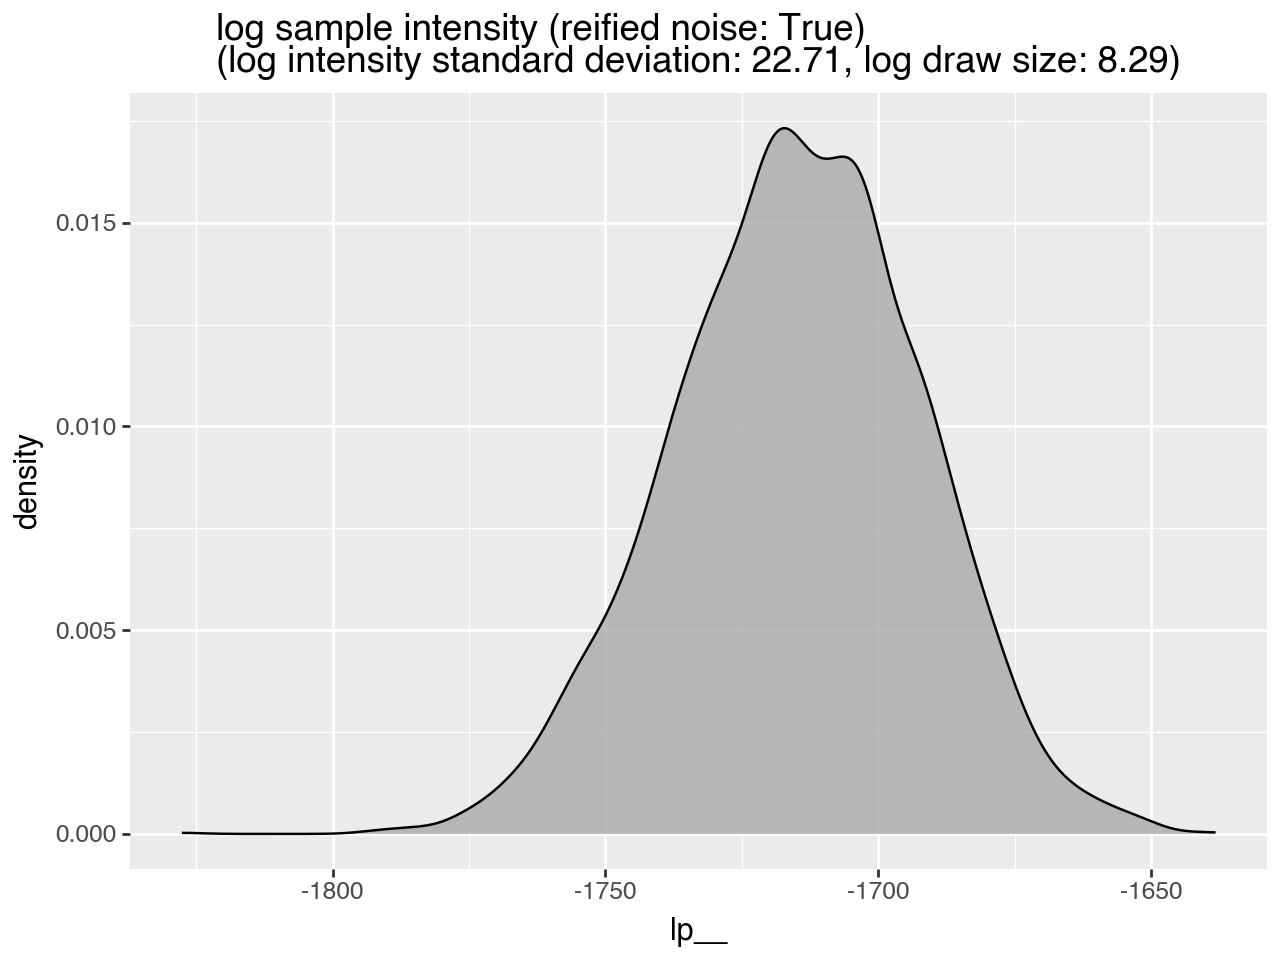


data {
  int<lower=1> n_vars;  // number of variables per alternative
  int<lower=5, upper=5> n_alternatives;  // number of items per presentation list
  int<lower=1> m_examples;  // number of examples
  array[m_examples] int<lower=0, upper=n_alternatives> pick_index;   // which item is picked, 0 means no pick
  matrix[m_examples, n_vars] x_passed_1;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_2;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_3;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_4;  // explanatory variables
  matrix[m_examples, n_vars] x_passed_5;  // explanatory variables
}
parameters {
  real beta_0;  // model parameters
  vector[n_vars] beta;  // model parameters
}
transformed parameters {
  array[n_alternatives] vector[m_examples] link;  // link values
  link[1] = beta_0 + x_passed_1 * beta;
  link[2] = beta_0 + x_passed_2 * beta;
  link[3] = beta_0 + x_passed_3 * beta;
  link[4] = beta_0 + x_passed_4 * beta;
  lin

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

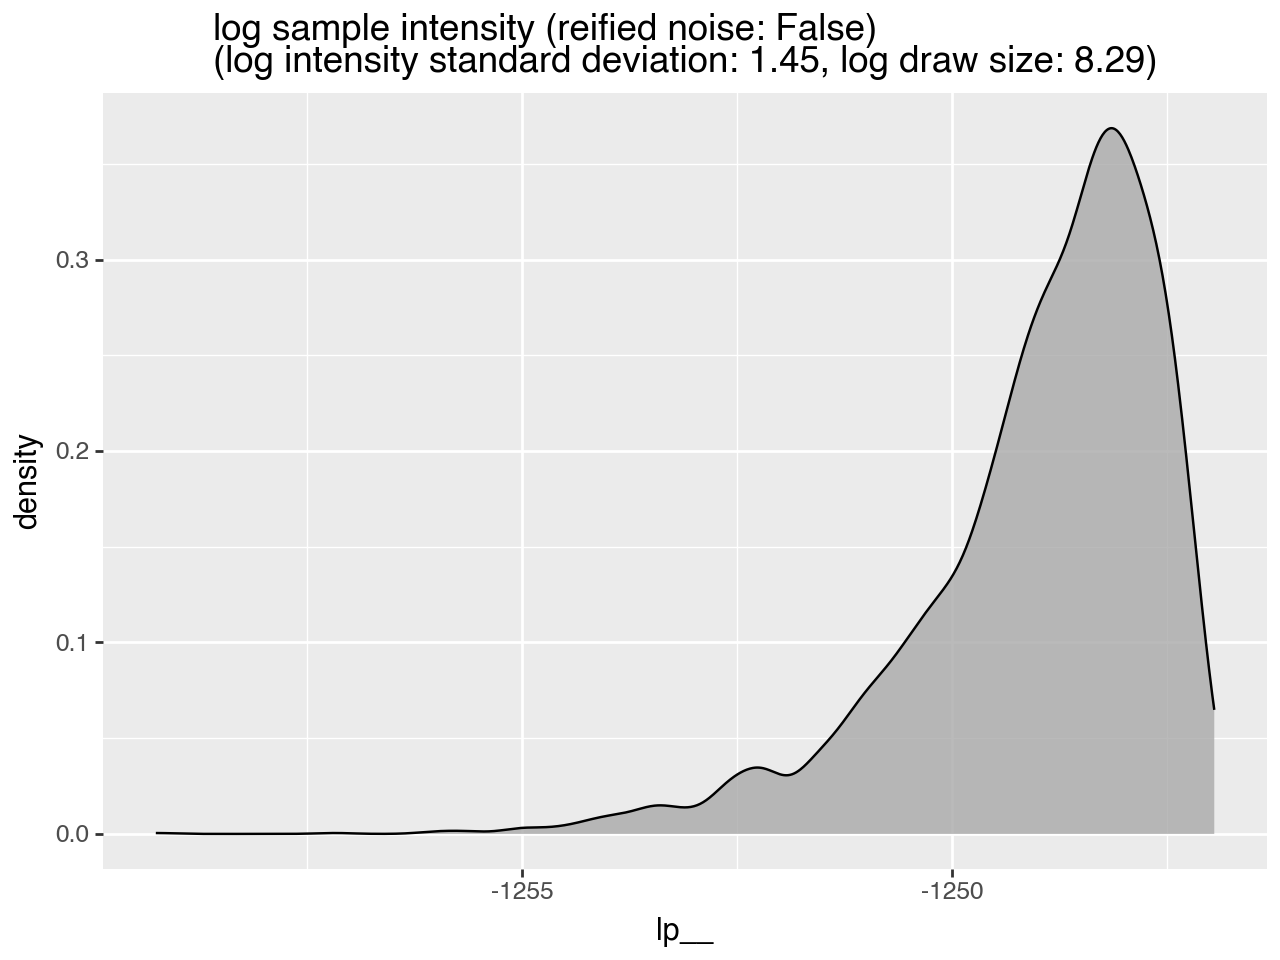

In [32]:
for reify_noise in [True, False]:
    run_Stan_experiment(reify_noise=reify_noise)

In [33]:
def model_prevalence(i: int, *, cf:pd.DataFrame, shift: float = 0.0):
    return np.mean(
        sigmoid(np.array(
           (examples.loc[:, list(explanatory_variables)] @ np.array(cf.loc[i, list(explanatory_variables)]))
            + cf.loc[i, 'beta_0'] + shift
            , dtype=float)))

def mk_f(i: int):
    def f_i(x):
        return model_prevalence(i, cf=coef_frame, shift=x) - p_implied
    return f_i

coef_frame['recovered prevalence'] = [model_prevalence(i, cf=coef_frame) for i in range(coef_frame.shape[0])]

In [34]:
d.loc[range(m_prefix), :].round(2)

,example_index,x1,x2,x3,data generation process,model from visible selections,model from pair differences,Stan MCMC (reified noise),Stan via optimizer (reified noise),Stan MCMC,Stan via optimizer
0,0,12.0,1.0,0.0,0.80,0.80,0.99,0.80,0.80,0.80,0.80
1,1,1.0,6.0,0.0,0.55,0.39,0.94,0.56,0.56,0.56,0.56
2,2,0.0,0.0,0.1,0.24,0.04,0.51,0.25,0.32,0.24,0.24
3,3,0.0,1.0,1.0,0.31,0.10,0.73,0.31,0.34,0.28,0.28


In [35]:

coef_frame.round(2)

,model,beta_0,x1,x2,x3,recovered prevalence
0,data generation process,-1.20,0.20,0.20,0.20,0.37
1,model from visible selections,-3.13,0.34,0.39,0.50,0.18
2,model from pair differences,0.00,0.32,0.41,0.57,0.75
3,Stan MCMC (reified noise),-1.08,0.19,0.19,0.07,0.37
4,Stan via optimizer (reified noise),-0.73,0.16,0.13,-0.06,0.40
5,Stan MCMC,-1.17,0.19,0.20,0.04,0.35
6,Stan via optimizer,-1.16,0.19,0.20,0.03,0.35


Try adjusting some the models to match our estimated underlying prevalence.

In [36]:
models_to_prevalence_correct = ['model from visible selections', 'model from pair differences']
coef_frame_shifted = (
    coef_frame
        .loc[range(coef_frame.shape[0]), :]
        .reset_index(drop=True, inplace=False))
coef_frame_shifted['beta_0'] = [
    coef_frame_shifted.loc[i, 'beta_0'] + fsolve(mk_f(i), 0.0)[0] 
    for i in range(coef_frame_shifted.shape[0])]
coef_frame_shifted = (
    coef_frame_shifted
        .loc[np.isin(coef_frame_shifted['model'], models_to_prevalence_correct), :]
        .reset_index(drop=True, inplace=False))
coef_frame_shifted['recovered prevalence'] = [model_prevalence(i, cf=coef_frame_shifted) for i in range(coef_frame_shifted.shape[0])]

d_shifted = (
    d
        .loc[:, ['example_index'] + list(explanatory_variables) + ['data generation process']]
        .reset_index(drop=True, inplace=False))
for i in range(coef_frame_shifted.shape[0]):
    d_shifted[coef_frame_shifted.loc[i, 'model']] = sigmoid(np.array(
        (d_shifted.loc[:, list(explanatory_variables)] @ np.array(coef_frame_shifted.loc[i, list(explanatory_variables)])) 
        + coef_frame_shifted.loc[i, 'beta_0'], dtype=float))



In [37]:
d_shifted.loc[range(m_prefix), :].round(2)

,example_index,x1,x2,x3,data generation process,model from visible selections,model from pair differences
0,0,12.0,1.0,0.0,0.80,0.94,0.92
1,1,1.0,6.0,0.0,0.55,0.71,0.72
2,2,0.0,0.0,0.1,0.24,0.15,0.14
3,3,0.0,1.0,1.0,0.31,0.29,0.29


In [38]:
coef_frame_shifted.round(2)

,model,beta_0,x1,x2,x3,recovered prevalence
0,model from visible selections,-1.78,0.34,0.39,0.50,0.38
1,model from pair differences,-1.85,0.32,0.41,0.57,0.38
